# Topic: Data Mining - Recommendation Systems
## Part 1: EDA


In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from PIL import Image
import random
from io import StringIO, BytesIO
import requests
from pytz import timezone
from IPython.display import display
import calendar
import matplotlib.pyplot as plt
import seaborn as sns 
from wordcloud import WordCloud, STOPWORDS
import operator
import os
import sys
from io import StringIO, BytesIO
import requests
import logging

In [2]:
!wget http://cseweb.ucsd.edu/~wckang/DVBPR/AmazonFashion6ImgPartitioned.npy

--2022-12-07 00:54:35--  http://cseweb.ucsd.edu/~wckang/DVBPR/AmazonFashion6ImgPartitioned.npy
Resolving cseweb.ucsd.edu (cseweb.ucsd.edu)... 132.239.8.30
Connecting to cseweb.ucsd.edu (cseweb.ucsd.edu)|132.239.8.30|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cseweb.ucsd.edu//~wckang/DVBPR/AmazonFashion6ImgPartitioned.npy [following]
--2022-12-07 00:54:35--  https://cseweb.ucsd.edu//~wckang/DVBPR/AmazonFashion6ImgPartitioned.npy
Connecting to cseweb.ucsd.edu (cseweb.ucsd.edu)|132.239.8.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3502475168 (3.3G)
Saving to: ‘AmazonFashion6ImgPartitioned.npy.2’

      AmazonFashion   0%[                    ]   3.52M  2.84MB/s               ^C


In [3]:
dataset = np.load("AmazonFashion6ImgPartitioned.npy", encoding="bytes",allow_pickle=True)
[user_train, user_validation, user_test, items, user_num, item_num] = dataset

# EDA

## 1: Figuring out why to use Images features for computing item similarity:

In [4]:
'''Measures all the interactions which an item and its related items get'''
items_interact = {}
for i in range(len(items)):
  if items[i][b'asin'].decode("utf-8") in items_interact:
    items_interact[items[i][b'asin'].decode("utf-8")]+=1
  else:
    items_interact[items[i][b'asin'].decode("utf-8")]= 1
  if b'related'in items[i] and b'also_viewed' in items[i][b'related']:
    for j in items[i][b'related'][b'also_viewed']:
      if j.decode("utf-8") in items_interact:
        items_interact[j.decode("utf-8")]+=1 
      else:
        items_interact[j.decode("utf-8")] = 1

In [5]:
items_interact_sorted = dict(sorted(items_interact.items(), key=lambda x: x[1], reverse=True)) 
final_dict = dict(zip(range(len(items_interact_sorted)), list(items_interact_sorted.values())))
#sort based on the number of interactions

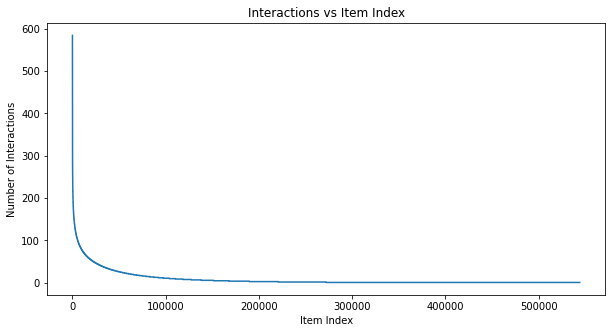

In [6]:
plt.figure(figsize=(10, 5))
plot = sns.lineplot(x=list(final_dict.keys()),y = list(final_dict.values()))
plot.set(xlabel='Item Index', ylabel='Number of Interactions', title='Interactions vs Item Index')
plt.show()

As we can see, there is a very evident, long tail. The fashion dataset suffers with the very famous cold-start issue. Only a very few items have a high number of interactions, most of the items have a very little data to work with

## 2: Taking a deeper look into the item feature set:

Id: B00JGTST2C
Title: Ecko Unltd. Men's Printed Stripe Shorts
Categories: Clothing, Shoes & Jewelry, Men, Clothing, Shorts, Pleated; 


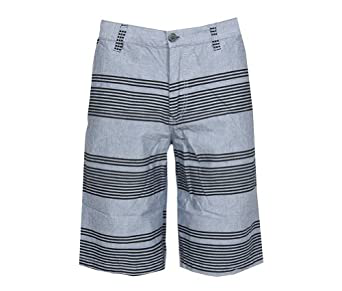

Id: B005QGMMU4
Title: Rialto 'Deliver' Women's , Silver E-Print - 7 M
Categories: Clothing, Shoes & Jewelry, Women, Shoes, Sandals; 


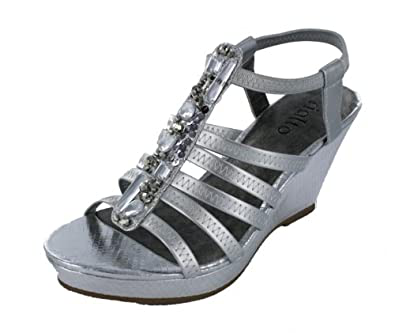

Id: B000VYORVI
Title: J.Renee Sacha Pump,Black/Tortoise,9.5M
Categories: Clothing, Shoes & Jewelry, Shoes & Accessories: International Shipping Available; Clothing, Shoes & Jewelry, J, J.Renee; Clothing, Shoes & Jewelry, Comfort Shoes; Clothing, Shoes & Jewelry, Women, Shoes, Pumps; 


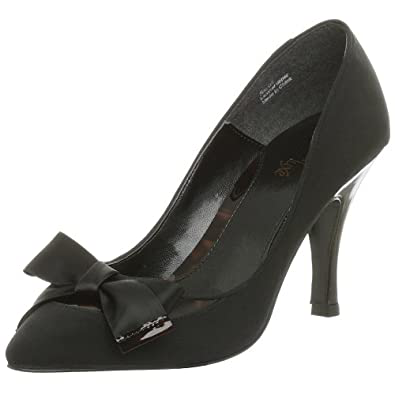

Id: B00770TV0G
Title: Crocs Wellie Patent Boot (Toddler/Litte Kid),Ultraviolet,9 M US Toddler
Categories: Clothing, Shoes & Jewelry, Shoes & Accessories: International Shipping Available; Clothing, Shoes & Jewelry, C, crocs; Clothing, Shoes & Jewelry, Girls, Shoes, Boots; Clothing, Shoes & Jewelry, Baby, Baby Girls; 


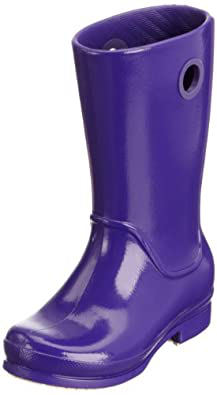

Id: B00829D274
Title: Wanted Shoes Women's Quinn Oxford,Black,6.5 M US
Categories: Clothing, Shoes & Jewelry, Shoes & Accessories: International Shipping Available; Clothing, Shoes & Jewelry, Women, Shoes, Oxfords; 


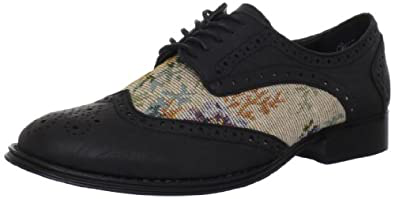

Id: B00E41FSN0
Title: Licia01 F-Suede Duo Tone Rhinestone Studded Toe Bow Metal Plated Platform Heel
Categories: Clothing, Shoes & Jewelry, Women, Shoes, Pumps; 


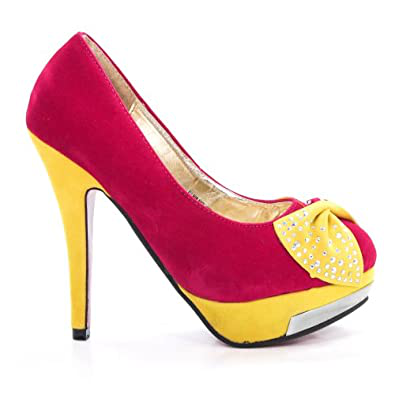

Id: B0036ZABIM
Title: Miss Sixty Women's Pu Fitted Blazer,White,Medium
Categories: Clothing, Shoes & Jewelry, M, Miss Sixty; Clothing, Shoes & Jewelry, Women, Clothing, Coats & Jackets; 


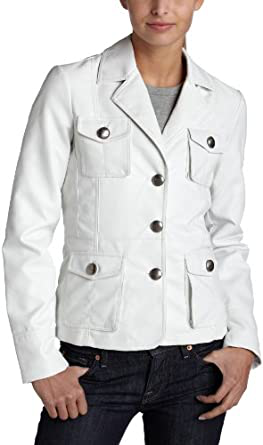

Id: B00GD4CZWS
Title: Sheinside Women White Long Sleeve Turtleneck Chunky Cable Knit Loose Sweater Pullover
Categories: Clothing, Shoes & Jewelry, Women, Clothing, Sweaters, Pullovers; 


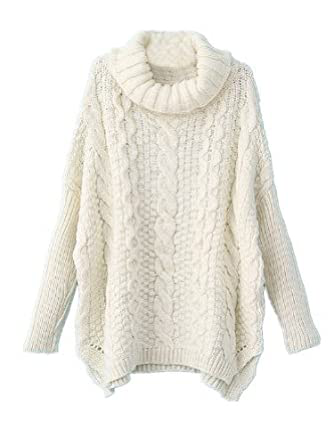

Id: B0095SQCJ6
Title: Mara Hoffman Women's Ruched Keyhole Long Sleeve Dress, Black, Medium
Categories: Clothing, Shoes & Jewelry, Women, Clothing, Dresses, Night Out & Cocktail; Clothing, Shoes & Jewelry, Women's Luxury Brands; 


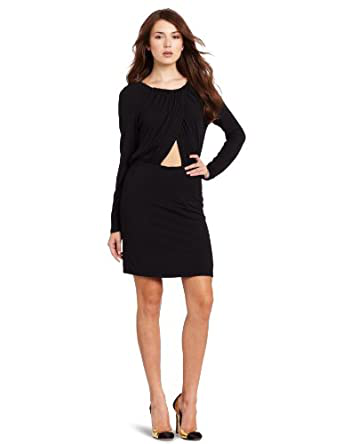

In [7]:
# Showcasing 10 random product items from the dataset:

for id in random.sample(range(len(items)), k=10):
    title = items[id][b'title'].decode("utf-8")
    asin = items[id][b'asin'].decode("utf-8")
    categories = items[id][b'categories']
    cat = ""
    for cat_list in categories:
        cat += ", ".join([c.decode("utf-8") for c in cat_list]) + "; "
    response = requests.get(items[id][b'imUrl'])
    if str(response) == '<Response [200]>':
      img = Image.open(BytesIO(response.content))
      print("Id: %s" % (asin))
      print("Title: %s" % (title))
      print("Categories: %s" % (cat))
      display(img)

## 3: A little bit of data processing and looking at how ratings are distributed in the dataset:

In [8]:
'''Get the distribution of ratings'''
#convert dictionary into dataframe
dataset = []
for i in range(user_num):
  count = 0
  for j in user_train[i]:
    dataset.append([j['reviewerID'],j['asin'],j['overall'],j['unixReviewTime'],j['reviewText']])
for i in range(user_num):
  count = 0
  for j in user_test[i]:
    dataset.append([j['reviewerID'],j['asin'],j['overall'],j['unixReviewTime'],j['reviewText']])
for i in range(user_num):
  count = 0
  for j in user_validation[i]:
    dataset.append([j['reviewerID'],j['asin'],j['overall'],j['unixReviewTime'],j['reviewText']])

In [9]:
# Creating different dataframes for different purposes
df = pd.DataFrame(dataset, columns =['user', 'item','rating','ReviewTime','ReviewText'])

In [10]:
df['ReviewTime'] = df['ReviewTime'].apply(datetime.fromtimestamp) #convert to supported data-time format  

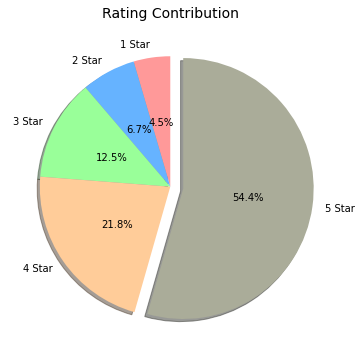

In [11]:
# Plotting a pie chart which illustrates the frequency of different ratings ranging from 1 to 5:

data = df.groupby("rating")['item'].count()
pie, ax = plt.subplots(figsize=[10,6])
explode = (0, 0, 0, 0,0.1)
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99','#aaac99']
labels = ["1 Star","2 Star","3 Star","4 Star","5 Star"]
plt.pie(x=data, explode =explode, labels=labels, pctdistance=0.5,shadow=True,colors=colors, autopct='%1.1f%%',startangle=90)
plt.title("Rating Contribution", fontsize=14);

This pie chart makes a clear suggestion that the reviews and ratings given are overwhelmingly positive, with more than half the reviews being a 5-star rating.

## 4. Taking a look at the most commonly used words across different kinds of reviews:

In [12]:
# Creating a dataframe where the ratings are 1 or 2 for the negative word cloud

bad_df = df[df['rating']<3]

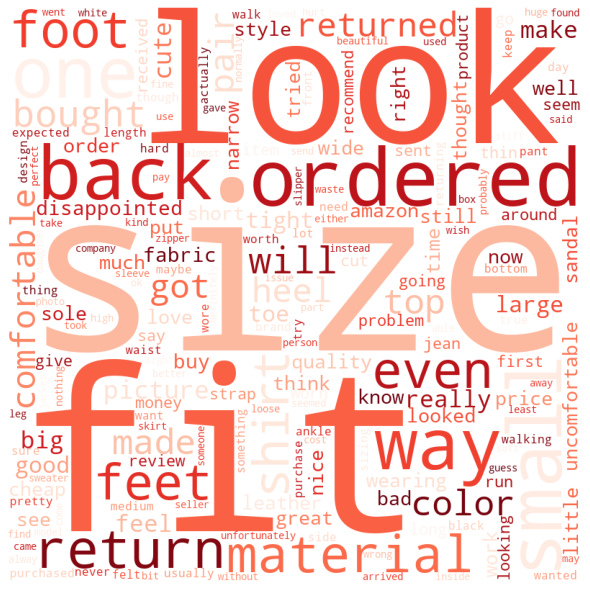

In [13]:
# Negative Word Cloud code:

comment_words = ''
stopwords = set(STOPWORDS)
stopwords.add('shoe')
stopwords.add('boot')
stopwords.add('shoes')
stopwords.add('dress')
stopwords.add('boots')
stopwords.add('wear')
# iterate through the csv file
for val in bad_df['ReviewText']:
    # typecaste each val to string
    val = str(val)
 
    # split the value
    tokens = val.split()
     
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "

wc = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords, colormap = 'Reds',
                min_font_size = 10).generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wc)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

In [14]:
# Creating a dataframe where the ratings are 3, 4 or 5 for the positive word cloud

good_df = df[df['rating']>=3]

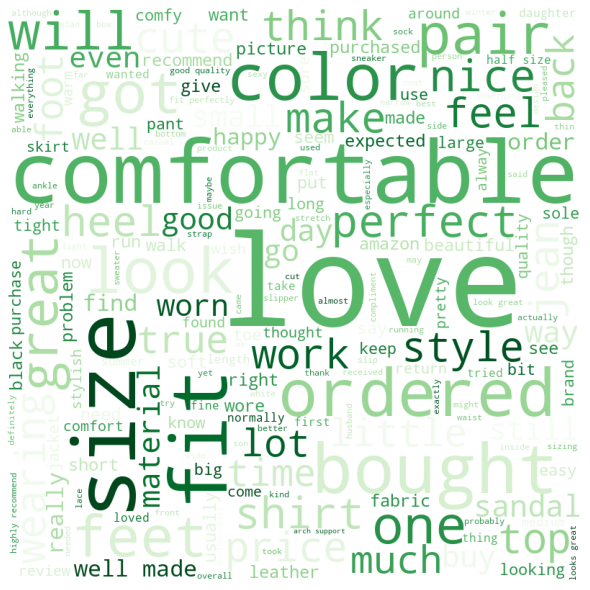

In [15]:
# Positive Word Cloud code:

comment_words = ''
stopwords = set(STOPWORDS)
stopwords.add('shoe')
stopwords.add('boot')
stopwords.add('shoes')
stopwords.add('dress')
stopwords.add('boots')
stopwords.add('wear')
# iterate through the csv file
for val in good_df['ReviewText']:
    # typecaste each val to string
    val = str(val)
 
    # split the value
    tokens = val.split()
     
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "

wc = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords, colormap = 'Greens',
                min_font_size = 10).generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wc)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

As we can see, the positive word cloud has considerably better words, such as ‘comfortable’, ‘love’, ‘great’ and ‘perfect’. On the other hand, the word cloud on the right has words such as ‘size’, ‘look’, ‘small’ and ‘fit’ which showcase why a user may not have liked a specific product.

## 5. Looking at the number of ratings across different categories of fashion:

In [16]:
# Creating a dictionary which stores the frequency of each product category in the dataset:

tems_interact = {}
categories = []
for i in range(len(items)):
  cat = items[i][b'categories']
  for j in cat[0]:
    categories.append(j.decode("utf-8"))

def CountFrequency(my_list):
    freq = {}
    for item in my_list:
        if (item in freq):
            freq[item] += 1
        else:
            freq[item] = 1
    freq = dict( sorted(freq.items(), key=operator.itemgetter(1),reverse=True))
    return freq
freq = {}
freq = CountFrequency(categories)

freq['Shoes & Accessories'] = freq['Shoes & Accessories: International Shipping Available']
del freq['Shoes & Accessories: International Shipping Available']

freq = dict( sorted(freq.items(), key=operator.itemgetter(1),reverse=True))

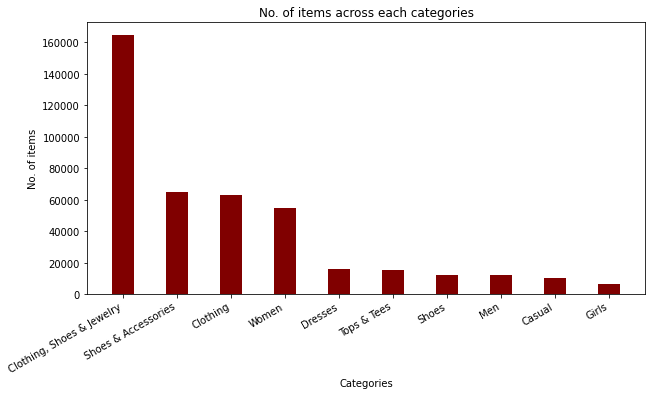

In [17]:
# Taking the 10 most frequent categories for plotting a bar graph:

first10pairs = {k: freq[k] for k in list(freq)[:10]}

keys = first10pairs.keys()
values = first10pairs.values()

fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot

plt.bar(keys, values, color ='maroon',
        width = 0.4)
plt.xticks(rotation=30, ha='right') 
plt.xlabel("Categories")
plt.ylabel("No. of items")
plt.title("No. of items across each categories")
plt.show()

The bar graph above indicates the number of ratings across different categories. Clothing, Shoes and Jewelry include pretty much all the products, which is why there are so many ratings in this specific category.

## 6. Showcasing how the ratings and number of interactions fluctuate with time:

In [18]:
df['review_year'] = pd.DatetimeIndex(df['ReviewTime']).year
df['review_month'] = pd.DatetimeIndex(df['ReviewTime']).month

In [19]:
conversion_dict ={index:month for index, month in enumerate(calendar.month_abbr) if month} #month-index mapping

In [20]:
df['month'] = df['review_month'].replace(conversion_dict) #convert month number with month name

In [21]:
def day_c(ep):
  return calendar.day_name[ep.weekday()]
#convert timestamp to day  

In [22]:
df["day"] = df["ReviewTime"].apply(day_c)
days = ['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']
Months = list(conversion_dict.values())

/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


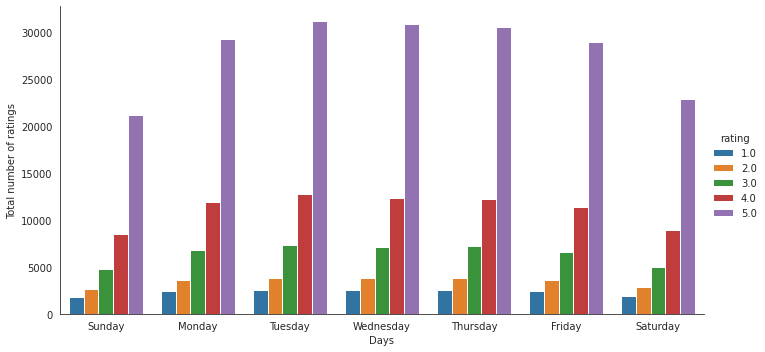

In [23]:
with sns.axes_style('white'):
    g = sns.factorplot("day", data=df, aspect=2.0,hue = 'rating',kind='count',order = days)
    g.set_ylabels("Total number of ratings")
    g.set_xlabels("Days")

This graph demonstrates a trend that there are several more reviews on weekdays than on weekends.

/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


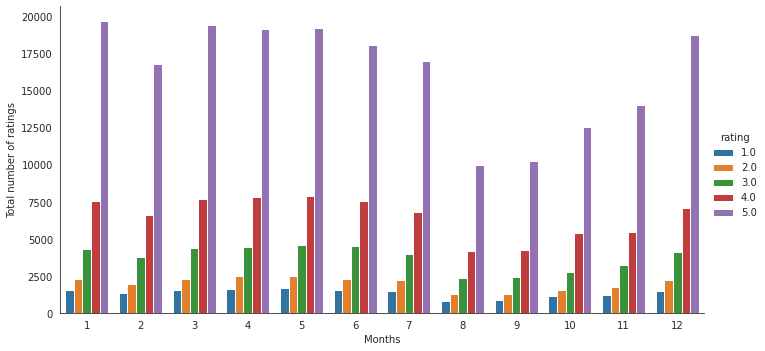

In [24]:
with sns.axes_style('white'):
    g = sns.factorplot("review_month", data=df, aspect=2.0,hue = 'rating',kind='count')
    g.set_ylabels("Total number of ratings")
    g.set_xlabels("Months")

/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


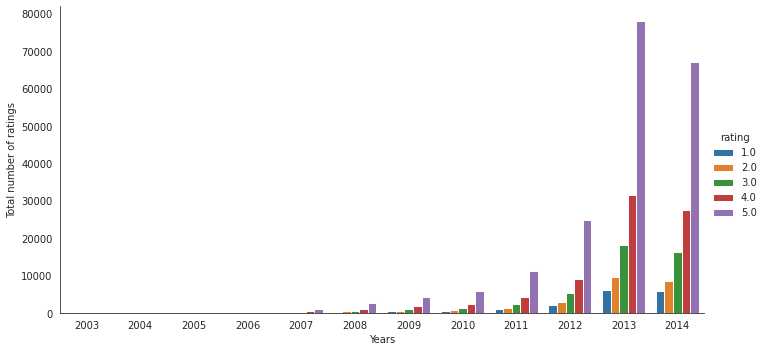

In [25]:
#Plotting over the years
with sns.axes_style('white'):
    g = sns.factorplot("review_year", data=df, aspect=2.0,hue = 'rating',kind='count')
    g.set_ylabels("Total number of ratings")
    g.set_xlabels("Years")

As we can see from the number of reviews with respect to years, the number of reviews every year keeps increasing steadily. This observation illustrates the rapid rate at which e-commerce sales have increased throughout the last decade. 

## 7. Shows how the activity of users and items affect the ratings


In [27]:
# Creating 3 datasets for different purposes
dataset_train = []
dt2=[]
dt3=[]
for i in range(user_num):
  count = 0
  for j in user_train[i]:
    dataset_train.append([j['reviewerID'],j['asin'],j['overall'],j['unixReviewTime'],j['reviewText']])
    dt2.append([j['reviewerID'],j['overall']])
    dt3.append([j['asin'],j['overall']])

In [28]:
# Creating different dataframes for different purposes

df = pd.DataFrame(dataset, columns =['user', 'item','rating','ReviewTime','ReviewText'])
df2=pd.DataFrame(dt2, columns =['user','rating'])
df3=pd.DataFrame(dt3, columns =['item','rating'])

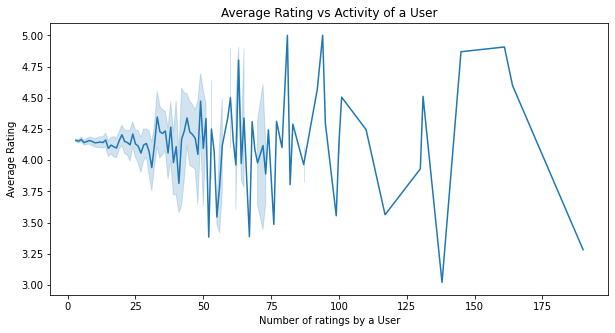

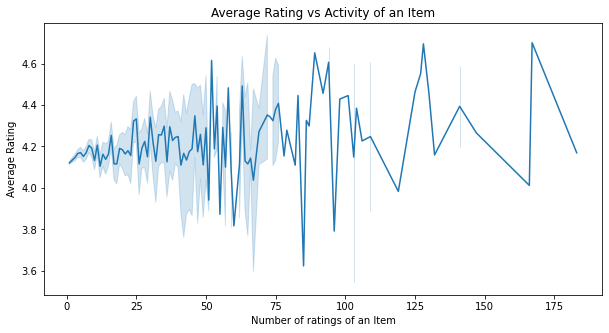

In [29]:
# Grouping the the dataframe by user and getting mean ratings and no of reviews by that user
df4=df2.groupby('user').agg(mean_rating=('rating', np.mean),count_review=('rating', np.count_nonzero))
df4=df4.sort_values(by=['count_review'],ascending=False)
# Grouping the the dataframe by item and getting mean ratings and no of reviews of that item
df5=df3.groupby('item').agg(mean_rating=('rating', np.mean),count_review=('rating', np.count_nonzero))
df5=df5.sort_values(by=['count_review'],ascending=False)
#Plotting the graph
plt.figure(figsize=(10, 5))
plot = sns.lineplot(x=pd.Series(df4.count_review),y = pd.Series(df4.mean_rating))
plot.set(xlabel='Number of ratings by a User', ylabel='Average Rating', title='Average Rating vs Activity of a User')
plt.show()
#Plotting the graph
plt.figure(figsize=(10, 5))
plot = sns.lineplot(x=pd.Series(df5.count_review),y = pd.Series(df5.mean_rating))
plot.set(xlabel='Number of ratings of an Item', ylabel='Average Rating', title='Average Rating vs Activity of an Item')
plt.show()

The first graph shows the mean ratings of most active users vary a lot in comparison to users who have reviewed less products who rate in a narrow range.

The second graph shows the mean ratings of most reviewed items vary a lot in comparison to items who have been less reviewed. Less reviewed item' s ratings lie in a narrow range.